# TensorFlow Tutorial #23
# 时间序列预测

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)/[GitHub中文](https://github.com/Hvass-Labs/TensorFlow-Tutorials-Chinese)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

中文翻译[ZhouGeorge](https://github.com/ZhouGeorge)

## 介绍

本教程试图用来自其他几个城市的天气数据来预测一个城市的未来天气。


因为我们将会处理任意长度的序列，我们将使用循环神经网络（RNN）。

你需要对TensorFlow和Kears比较熟悉，见教程 #01和 #03-C，循环神经网络的基础见教程 #20。


## 位置

我们将使用1980-2018年期间，丹麦（[Denmark](https://en.wikipedia.org/wiki/Denmark)）的五个城市的天气数据：


* **[Aalborg](https://en.wikipedia.org/wiki/Aalborg)** 天气数据实际上来自于一个空军基地，也就是 [The Hunter Corps (Jægerkorps)](https://en.wikipedia.org/wiki/Jaeger_Corps_(Denmark) 的所在地
* **[Aarhus](https://en.wikipedia.org/wiki/Aarhus)** 是 [c++的发明者](https://en.wikipedia.org/wiki/Bjarne_Stroustrup) 和 [Google V8 JavaScript Engine](https://en.wikipedia.org/wiki/Chrome_V8) 开发的所在地.
* **[Esbjerg](https://en.wikipedia.org/wiki/Esbjerg)** 有一个很大的渔港。
* **[Odense](https://en.wikipedia.org/wiki/Odense)** 是童话作家的诞生之城 [H. C. Andersen](https://en.wikipedia.org/wiki/Hans_Christian_Andersen).
* **[Roskilde](https://en.wikipedia.org/wiki/Roskilde)** 有一座古老的大教堂，有丹麦皇室的坟墓。

下面的地图展示了这些城市在丹麦的位置：

![Map of Denmark](images/Denmark.jpg)

下面的图显示了丹麦在欧洲的位置：
![Map of Europe](images/Europe.jpg)

## 流程图

在这份教程中，我们取来自5个城市的当前和过去的天气数据（尽管下面的流程图显示了2个城市），尝试去预测丹麦城市"Odense"未来24小时的天气。


我们使用一个循环神经网络(RNN)，因为它可以处理任意长度的序列。在训练过程中，我们将用训练集中1344数据点（8周）的子序列，每个数据点或观察点有20个输入信号是关于每个城市的温度，压力，等等。然后我们训练这个神经网络，让它就能输出3个信号，关于未来的温度、压力和风速。

![Flowchart](images/23_time_series_flowchart.png)

## 导入

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

/home/magnus/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


我们需要从Keras中导入一些模块。

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

开发环境 Python 3.6（Anaconda）以及其他包的版本：


In [3]:
tf.__version__

'1.5.0'

In [4]:
tf.keras.__version__

'2.1.2-tf'

In [5]:
pd.__version__

'0.22.0'

## 加载数据

丹麦5个城市的原始天气数据会在下面自动下载。

原始的天气数据获取地址 [National Climatic Data Center (NCDC), USA](https://www7.ncdc.noaa.gov/CDO/cdoselect.cmd).

他们的网站和数据库访问非常混乱。此外，原始数据文件必须在读取之前手动编辑。因此，如果您想要下载另一个区域的天气数据，您应该会遇到一些挑战。下面的python模块提供了一些功能，如果你想使用新的天气数据，可能会有所帮助，但是你必须修来源代码去适应你的数据格式。


In [6]:
import weather

数据集会自动下载。大约35 MB.

In [7]:
weather.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


数据集中用到城市的列表

In [8]:
cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

加载数据并以每间隔60分钟为周期再次采样。丢失的数据用线性插值补充。第一次加载数据花费大约30秒，但是如果用cache-file，下一次加载就会变得非常快。


In [9]:
%%time
df = weather.load_resampled_data()

CPU times: user 16 ms, sys: 16 ms, total: 32 ms
Wall time: 30.1 ms


下面是原始数据集顶部的几行。


In [10]:
df.head()

Aalborg                                    Aarhus  \
                         Temp     Pressure WindSpeed     WindDir   Temp   
DateTime                                                                  
1980-03-01 11:00:00  5.000000  1007.766667      10.2  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000      10.3  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667       9.7  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333      11.1  283.333333    5.0   
1980-03-01 15:00:00  4.000000  1008.200000      11.3  280.000000    5.0   

                                                     Esbjerg           \
                        Pressure WindSpeed WindDir      Temp Pressure   
DateTime                                                                
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.083333      NaN   
1980-03-01 12:00:00  1008.600000      13.4   280.0  6.583333      NaN   
1980-03-01 13:00:00  1008.433333      15.4   280.0  6.888889      NaN   
1980-03-01 14:00:00  1008.266667      14.9   300.0  6.222222      NaN   
1980-03-01 15:00:00  1008.100000      17.0   290.0  5.555556      NaN   

                                              Odense                          \
                     WindSpeed     WindDir      Temp     Pressure  WindSpeed   
DateTime                                                                       
1980-03-01 11:00:00  12.383333  310.000000  6.142857  1011.066667  12.585714   
1980-03-01 12:00:00  12.883333  310.000000  7.000000  1011.200000  11.300000   
1980-03-01 13:00:00  13.244444  309.444444  7.000000  1011.300000  12.118182   
1980-03-01 14:00:00  12.911111  306.111111  6.857143  1011.400000  12.742857   
1980-03-01 15:00:00  12.577778  302.777778  6.000000  1011.500000  12.400000   

                             Roskilde                                  
                    WindDir      Temp Pressure  WindSpeed     WindDir  
DateTime                                                               
1980-03-01 11:00:00   290.0  5.000000      NaN  11.466667  280.000000  
1980-03-01 12:00:00   290.0  5.000000      NaN  12.466667  280.000000  
1980-03-01 13:00:00   290.0  5.166667      NaN  13.133333  278.333333  
1980-03-01 14:00:00   290.0  5.833333      NaN  12.300000  270.000000  
1980-03-01 15:00:00   290.0  4.833333      NaN  12.300000  270.000000

### 确实数据

Esbjerg和Roskilde两个城市大气压的数据有所缺失，从下面的两个图可以看到。

因为我们采用再次采样的数据，我们要用通过邻近值的线性插值来填补缺失的数据，这些值在图中出显示为长直线。

这可能混淆神经网络。简单起见，我们将这两个信号从数据中移除了。

但是它只是短期的数据缺失了，你可以创建一个预测模型用其它输入信号生成这些缺失值。然后你可以把这些生成的值加入到数据集中。


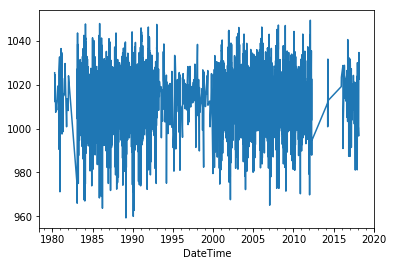

In [11]:
df['Esbjerg']['Pressure'].plot()

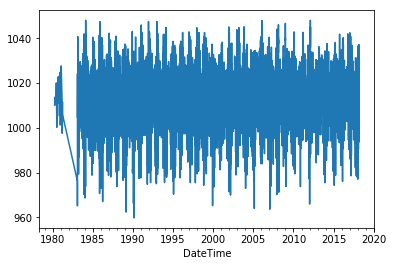

In [12]:
df['Roskilde']['Pressure'].plot()

在移除两个型号之前，数据集中有20个输入信号。


In [13]:
df.values.shape

(333109, 20)

然后我们将有数据缺失的信号移除。
Then we remove the two signals that have missing data.

In [14]:
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)

现在数据中只有18个输入信号。


In [15]:
df.values.shape

(333109, 18)

我们可以验证这两个数据列确实已经被删除了。


In [16]:
df.head(1)

Aalborg                                Aarhus           \
                       Temp     Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                     
1980-03-01 11:00:00     5.0  1007.766667      10.2   280.0    5.0   1008.3   

                                        Esbjerg                       Odense  \
                    WindSpeed WindDir      Temp  WindSpeed WindDir      Temp   
DateTime                                                                       
1980-03-01 11:00:00      15.4   290.0  6.083333  12.383333   310.0  6.142857   

                                                    Roskilde             \
                        Pressure  WindSpeed WindDir     Temp  WindSpeed   
DateTime                                                                  
1980-03-01 11:00:00  1011.066667  12.585714   290.0      5.0  11.466667   

                             
                    WindDir  
DateTime                     
1980-03-01 11:00:00   280.0

### 错误的数据

数据中有一些错误的数据。如下图显示的一样，Odense的气温突然上升到50摄氏度。但是丹麦历史最高气温只有36.4摄氏度，最低气温只有-31.2摄氏度。所以这个数据很明显是错误的，我们不会在本教程中纠正任何数据错误。


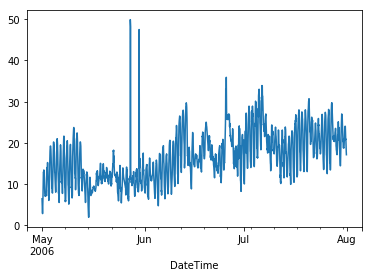

In [17]:
df['Odense']['Temp']['2006-05':'2006-07'].plot()

考虑到同一时期丹麦其他城市的气温只有在10°左右，所以也可以确认这是一个错误。因为这个国家很小，所以不可能丹麦的一个城市有50°而其它城市只有10°。


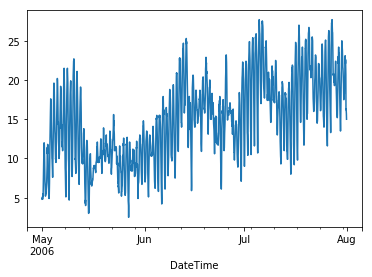

In [18]:
df['Aarhus']['Temp']['2006-05':'2006-07'].plot()

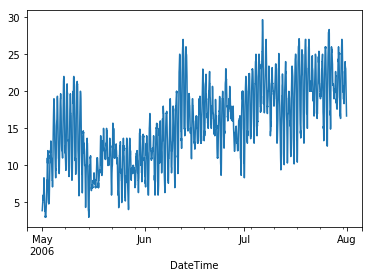

In [19]:
df['Roskilde']['Temp']['2006-05':'2006-07'].plot()

### 加入数据

我们可以给数据加入一些输入信号去帮助我们模型做预测。

举个例子，温度不能反应被测量是在白天还是晚上，在夏天还是冬天。这个模型必须从周围的数据点进行推断，这可能不是很准确的判断、是否是一个异常温暖的冬天，或者是一个异常寒冷的夏天，或是白天还是黑夜。因此，拥有这些信息可以极大地改变模型预测下一个输出的准确度。

尽管数据集确实包含每个观测的日期和时间信息,它只在索引中使用，以便对数据进行排序.因此我们向数据集中添加一些输入信号，day-of-year（1-366），hour-of-day（0-23）。


In [20]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

### 预测的目标数据

我们将尝试和预测这个城市未来的天气。

In [21]:
target_city = 'Odense'

我们尝试预测这些信号。


In [22]:
target_names = ['Temp', 'WindSpeed', 'Pressure']

##### 下面是我们将改变目标数据的时间步长的数量。我们的数据集被以间隔每小时重新采样，所以24小时内有24个观察结果。

如果我们希望预测将来24小时的天气，我们将数据转换为24个时间步长。如果我们想要预测将来7天的天气，我们将数据转换成7 * 24 个时间步长。


In [23]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

根据时间转换过的数据创建一个新的数据帧

**注意负的时间转换**

In [24]:
df_targets = df[target_city][target_names].shift(-shift_steps)

**警告!** 你应该复查一下你以正确的方向转换数据！我们想要预测未来，而不是过去！

经过转换的数据帧是混乱的，因为尽管我们转换了数据，Pandas任然保持原始的时间戳。你可以通过比较原始数据和时间转化后的数据帧，检查时间转换是正确的

这是原始数据帧的前`shift_steps + 5` 行：

In [25]:
df[target_city][target_names].head(shift_steps + 5)

Temp  WindSpeed     Pressure
DateTime                                             
1980-03-01 11:00:00  6.142857  12.585714  1011.066667
1980-03-01 12:00:00  7.000000  11.300000  1011.200000
1980-03-01 13:00:00  7.000000  12.118182  1011.300000
1980-03-01 14:00:00  6.857143  12.742857  1011.400000
1980-03-01 15:00:00  6.000000  12.400000  1011.500000
1980-03-01 16:00:00  4.909091  12.618182  1011.688889
1980-03-01 17:00:00  3.953488  12.646512  1011.877778
1980-03-01 18:00:00  3.674419  11.725581  1012.066667
1980-03-01 19:00:00  3.395349  10.804651  1012.255556
1980-03-01 20:00:00  3.116279   9.883721  1012.444444
1980-03-01 21:00:00  2.837209   8.962791  1012.633333
1980-03-01 22:00:00  2.558140   8.041860  1012.822222
1980-03-01 23:00:00  2.279070   7.120930  1013.011111
1980-03-02 00:00:00  2.000000   6.200000  1013.200000
1980-03-02 01:00:00  2.076923   7.738462  1012.366667
1980-03-02 02:00:00  2.538462   7.969231  1011.533333
1980-03-02 03:00:00  3.000000   8.200000  1010.700000
1980-03-02 04:00:00  3.000000   7.927273  1010.100000
1980-03-02 05:00:00  2.916667   7.658333  1009.500000
1980-03-02 06:00:00  2.416667   7.408333  1008.900000
1980-03-02 07:00:00  2.000000   7.100000  1008.300000
1980-03-02 08:00:00  2.142857   6.542857  1007.700000
1980-03-02 09:00:00  3.000000   6.200000  1007.100000
1980-03-02 10:00:00  2.833333   8.350000  1006.466667
1980-03-02 11:00:00  2.000000   6.828571  1005.833333
1980-03-02 12:00:00  2.000000   8.200000  1005.200000
1980-03-02 13:00:00  0.166667   9.216667  1004.766667
1980-03-02 14:00:00  1.000000  11.885714  1004.333333
1980-03-02 15:00:00  1.000000  12.400000  1003.900000

下面是经过时间转换数据帧的前5行。除了时间戳之外，它应该与上面显示的最后5行相同。


In [26]:
df_targets.head(5)

Temp  WindSpeed     Pressure
DateTime                                             
1980-03-01 11:00:00  2.000000   6.828571  1005.833333
1980-03-01 12:00:00  2.000000   8.200000  1005.200000
1980-03-01 13:00:00  0.166667   9.216667  1004.766667
1980-03-01 14:00:00  1.000000  11.885714  1004.333333
1980-03-01 15:00:00  1.000000  12.400000  1003.900000

时间转换过的数据帧于原始数据帧有相同的长度，但是最后观察结果是`NaN`（不是一个数字），应为数据已经向后移动了，所以我们试图改变原始数据帧中不存在的数据。


In [27]:
df_targets.tail()

Temp  WindSpeed  Pressure
DateTime                                      
2018-03-01 19:00:00   NaN        NaN       NaN
2018-03-01 20:00:00   NaN        NaN       NaN
2018-03-01 21:00:00   NaN        NaN       NaN
2018-03-01 22:00:00   NaN        NaN       NaN
2018-03-01 23:00:00   NaN        NaN       NaN

### NumPy 数组

我们将Pandas数据帧转换成NumPy数组，它可以输入到神经网络。我们也移除numpy数组的最后一部分，因为它的目标数据存在`NaN`，而且我们只想要有效的数据并且输入与输出的形状是相同的。

下面是是输入的信号：


In [28]:
x_data = df.values[0:-shift_steps]

In [29]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 20)


下面是输出信号（或者说目标信号）：

In [30]:
y_data = df_targets.values[:-shift_steps]

In [31]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 3)


这是数据集中的观测的数目（又叫数据点或样本）：

In [32]:
num_data = len(x_data)
num_data

333085

数据集中训练集所占的比例：


In [33]:
train_split = 0.9

训练集中观测的数量：

In [34]:
num_train = int(train_split * num_data)
num_train

299776

测试集中观测的数量：


In [35]:
num_test = num_data - num_train
num_test

33309

下面是训练集和测试集输入的信号：


In [36]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

333085

下面是训练集和测试集输出的信号：

In [37]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

333085

这是输出信号的个数：


In [38]:
num_x_signals = x_data.shape[1]
num_x_signals

20

这是输出信号的个数：


In [39]:
num_y_signals = y_data.shape[1]
num_y_signals

3

### 数据缩放


数据集包含范围广泛的值：

In [40]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -27.0
Max: 1050.8


神经网络在-1到1值之间工作最好，所以我们需要将数据输入到神经网络之前对它缩放。

我们可以用 `scikit-learn` 来完成。

我们先为输入信号创建一个缩放对象。


In [41]:
x_scaler = MinMaxScaler()

然后我们检测训练数据集的取值范围然后进行缩放。

In [42]:
x_train_scaled = x_scaler.fit_transform(x_train)

除了小的舍取误差，数据已经被缩放到0到1。


In [43]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


我们对测试集的输入信号也用了相同的缩放对象。

In [44]:
x_test_scaled = x_scaler.transform(x_test)

目标数据来自与输入信号相同的数据集，因为它是一个城市的天气时间偏移的数据。但是目标数据可以是不同来源，不同范围的值，因此，我们为目标数据创建了一个单独的缩放对象。


In [45]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## 数据生成器

数据集已经准备好了，是2维的numpy数组。训练数据大约有300k个观测点，包含20个输入信号和3个输出信号。

下面是输入和输出数据的数组形状：


In [46]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(299776, 20)
(299776, 3)


代替用全部的300k观测点的序列去训练循环神经网络，我们将用下面的函数将训练数据随机地划分成更小的子序列。

In [47]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

我们使用大的批大小，这样可以更有效地使用GPU。你可以根据你GPU的RAM和在下面选择的`sequence_length`去调整这个数。


In [48]:
batch_size = 256

我们使用的序列长度是1344，它意味着每个随机的序列包含了8周的观测点。一个时间步长对应1个小时，缩影24 x 7 个步长对应1周，24 x 7 x 8 对应8周。


In [49]:
sequence_length = 24 * 7 * 8
sequence_length

1344

然后我们创建批的生成器。

In [50]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

我们可以测试一下它是否有效。

In [51]:
x_batch, y_batch = next(generator)

它给我们一个随机256个序列的批，每个序列包含1344个观测点，每个观测点有20个输入信号和3个输出信号。


In [52]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 3)


我们可以将20个输入信号中的一个画出来。


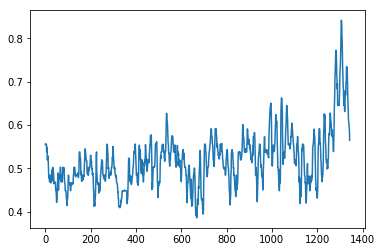

In [53]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

我们也可以将输出信号中的一个画出来，这是我们希望模型能去学习如何根据20个输入信号预测的结果。


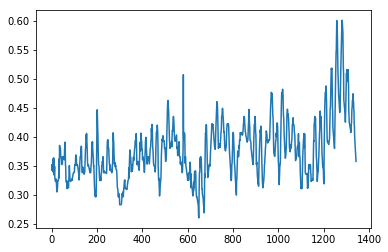

In [54]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

# 验证集

神经网络训练的很快，所以我们能很容易地运行很多个epoch。但是这里有模型对训练集过拟合的风险，所以它不能很好地推广到没见过的数据。因此我们检测模型每个epich后在测试集上的性能，并且只有在测试集上性能得到了提升了，才保存模型的权重。

批生成器从训练数据中随机选择一批短序列，并在训练过程中使用它。但是对于验证数据，我们将运行测试集中全部序列并且在测量全部的预测精度。


In [55]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## 创建循环神经网络

我们现在准备创建一个循环神经网络（RNN）。我们将使用Kears API，因为它很易用。关于Keras的内容见教程 #03-C，关于神经网络更多的信息见教程 #20。


In [56]:
model = Sequential()

我们在网络中加入一个GRU（Gated Recurrent Unit）。在序列的每个步长它有512个输出。

注意，因为是模型的第一层，Keras需要知道它输入的形状，输入一批任意长度的序列（用 `None`表示），每个观测点有(`num_x_signals`)个输入信号。


In [57]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


GRU输出一批512个值的序列。我们想要预测3个输出信号，所以我们加入了全连接层，将512值映射到3个值。

数据集中的输入信号已经用被限制到0-1之间。所以我们也用Simoid激活函数限制神经网络的输出在0-1之间。



In [58]:
model.add(Dense(num_y_signals, activation='sigmoid'))

使用Simoid函数有一个问题，就是我们只能输出与训练数据相同范围的值。

举个例子，如果训练数据温度只在-20°到+30°之间的，然后缩放对象会将-20°映射到0，将+30°映射到1。如果我们用Sigmoid函数限制神经网络的输出在0到1之间，那么结果只能映射回-20°到+30°范围的温度

我们可以用线性激活函数来代替。它允许输出成为任意的值。对于简单的网络结构，标准初始化可能有效，但是对于更复杂的神经网络，比如更多层的，它可能需要用很小的值去初始化权重来避免训练过程中出现`NaN`值。你可能需要试验一下，才能让它正常工作。


In [59]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### 损失函数

我们采用均方误差（MSE）作为损失函数，它可以被最小化。它测量了模型的输出与真实输出信号的相似程度。

然而，在序列的开始，这个模型只看到了前几个时间步长的输入信号，所以它产生的输出可能非常不准确。使用早期时间步长的损失值可能会导致模型扭曲其后续输出。因此我们给模型一个50个步长的“预热期”，为了提高它在之后时间步长中的准确率，预热期间我们不会在损失函数中使用他的准确率。


In [60]:
warmup_steps = 50

In [61]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### 编译模型

这是我们要用的优化器和开始的学习率。


In [62]:
optimizer = RMSprop(lr=1e-3)

然后我们编译Keras的模型。


In [63]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


这是一个非常小的模型，它只有2层。输出的形状是`(None, None, 3)`，意味着模型会输出一批有任意数量的序列，每个序列有任意数量的观测点，每个观测点有3个信号。这对应于我们想要预测的3个目标信号。


In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         818688    
_________________________________________________________________
dense_1 (Dense)              (None, None, 3)           1539      
Total params: 820,227
Trainable params: 820,227
Non-trainable params: 0
_________________________________________________________________


### 回调函数

在训练时，我们希望保存checkpoints并将进展记录到TensorBoard中，所以我们用了Keras中的相应回调。

下面是在训练时保存checkpoints的回调。

In [65]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

下面是用于当在验证集上性能表现的更糟时停止优化的回调。

In [66]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

下面是在训练时写TensorBoard日志的回调。

In [67]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

这个回掉函数用于验证损失相对上一个epoch（`patience=0`）没有得到提升，就进一步减少优化器的学习率。学习率是通过乘以给定的系数来减小。我们之前设定学习率是1e-3，所以当它乘以0.1时，学习率会变成1e-4。并且我们不希望学习率比这更低。

In [68]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [69]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## 训练循环神经网络

现在我们可以训练这个神经网络。

注意一个“epich"不是对应处理一遍完整的训练集，因为批生成器是重训练集中随机选取子序列。于是我们选择了`steps_per_epoch`，这样一个“epoch”就能在几分钟被处理完。

根据这些设置，在GTX 1070上处理每个“epoch”大约花费2.5分钟。在14个“epoch”之后优化停止了，因为验证损失在5个“epoch”后没有减少。整个优化过程大概用了35分钟。
With these settings, each "epoch" took about 2.5 minutes to process on a GTX 1070. After 14 "epochs" the optimization was stopped because the validation-loss had not decreased for 5 "epochs". This optimization took about 35 minutes to finish.
还要注意的是，损失有时会变成 `NaN`(不是一个数）。这通常是通过重启和再次运行Notebook来解决。但是这也可能是由你的神经网络结构引起的，例如学习率，批大小，序列长度等等，这种情况下你可能需要调整这些设置。

In [ ]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

### 加载 Checkpoint
因为我们在训练模型时使用了early-stopping，在模型停止训练之前的几个epoch内，模型在测试集上的性能可能已经变得更糟了。因此我们需要重载最近保存的checkpoint，它应该是测试集上性能最好的模型。


In [70]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## 测试集上的性能

我们现在可以评价测试集上的性能。这个函数期望有一批数据输入，但是我们只用测试集上一个长的时间序列，所以我们只是扩展了数组维数来创建一个带有那个序列的批。

In [71]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================]1/1 [==============================] - 4s 4s/step



In [72]:
print("loss (test-set):", result)

loss (test-set): 0.0021468019112944603


In [73]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## 生成预测

这个辅助函数用于画出预测结果和正确的输出信号


In [74]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

我们现在可以画出一个预测输出信号的例子。重要的是理解这些图显示的是什么，因为它们实际上比你想象的要复杂一点。

这些图只显示了输出信号，并没有显示用于预测输出信号的这20个输入信号。在这些图上输入信号和输出信号之间的时间偏移是固定。这个模型**总是**预测输出未来的24个小时（根据上面定义的`shift_steps`变量）的信号。所以这个图的x轴仅仅显示了到目前为止，预测模型已经见过多少个时间步长的输入信号。

在前30-50个时间步长预测并不准确，因为在这个点模型见过的输入数据非常少。
这个模型为输入数据的每个时间步长生成一个输出的时间步长，所以当模型只运行了几个时间步长时，它对输入信号的历史知道的很少，不能做出正确的预测。该模型需要在其预测的输出信号被使用之前，通过处理大约30-50个时间步骤来“热身”。

这也是为什么我们当我们在损失函数中计算均方误差时忽视了前50个时间步长的“预热期”。在图中用灰色的区域代表“预热期”。

让我们从训练数据的一个例子开始。这是模型在训练过程中看见过的数据，所以它应该表现得相当好。


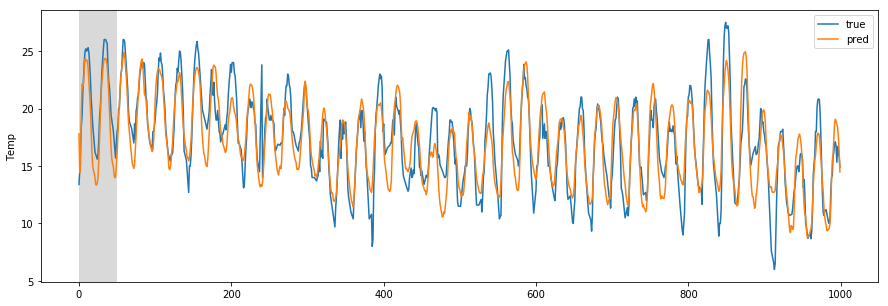

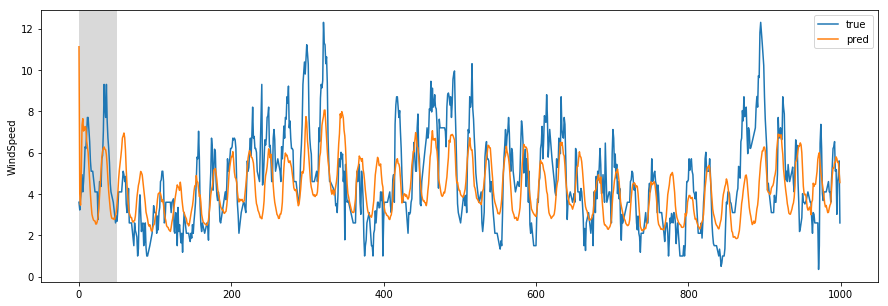

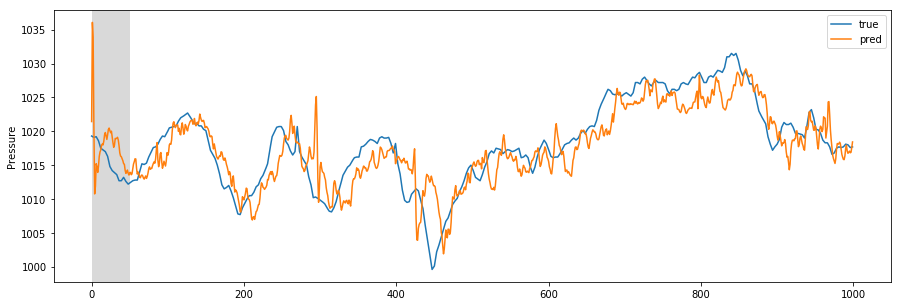

In [75]:
plot_comparison(start_idx=100000, length=1000, train=True)

这个模型能够很好地预测整个温度的振荡，但是峰值有时不准确。对于风速，整体振荡预测的相当好，但是峰值预测的相当不准确。对于气压，总体的曲线形状已经被预测了，但似乎有轻微的滞后，而且与原始信号的平滑度相比，预测的曲线有很大的噪音。

### 奇怪的例子

下面是训练集中另一个例子。

注意到温度在一天内没有明显的振荡（这张图显示了近42天）。温度通常会在每天振荡，例如在上面的图中每天的温度振荡非常明显。目前还不清楚这段时期是否有异常稳定的温度，或者是否存在数据错误。


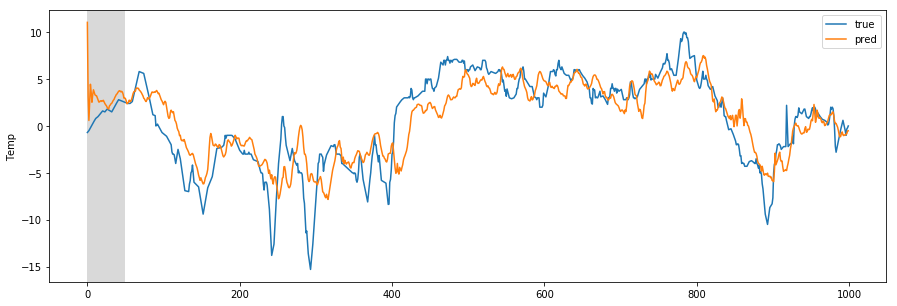

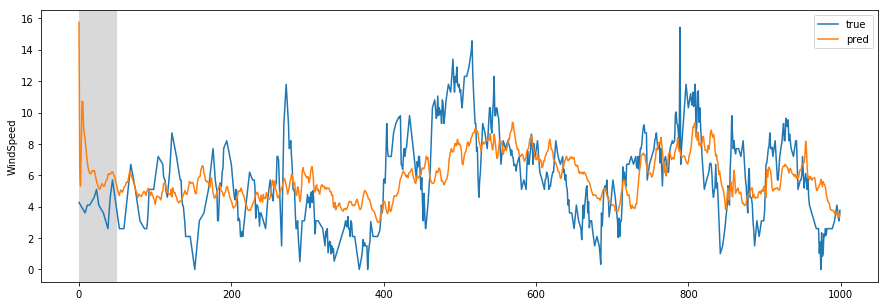

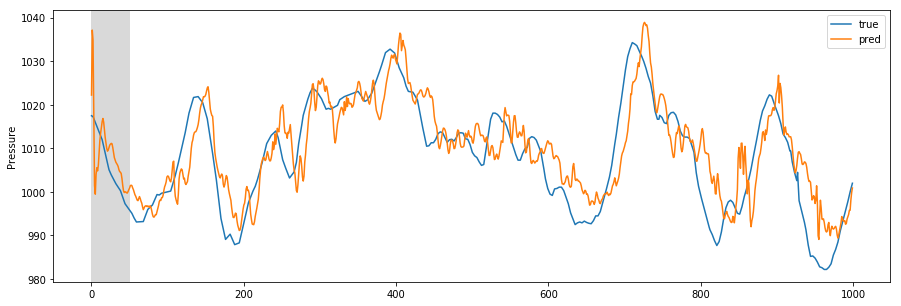

In [76]:
plot_comparison(start_idx=200000, length=1000, train=True)

做为检查，我们可以直接从采样的数据集中直接绘制信号，看起来相似。


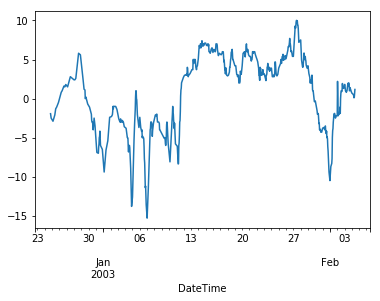

In [77]:
df['Odense']['Temp'][200000:200000+1000].plot()

我们可以画出相同时期的原始数据，它没有被二次采样。这看起来也很相似。

所以要么是这段时期的温度异常稳定，要么是来自于互联网天气数据库的原始数据中的存在错误。


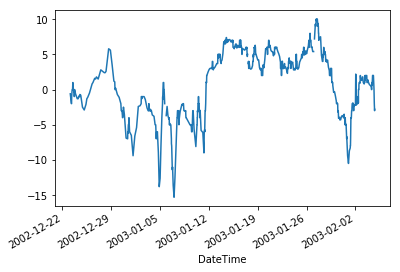

In [78]:
df_org = weather.load_original_data()
df_org.xs('Odense')['Temp']['2002-12-23':'2003-02-04'].plot()

### 测试集中的例子

仙子啊考虑测试集中的例子。这个些数据在训练期间没有被模型见过。

温度预测得相当好，尽管高峰有时是不准确的。

风速没有被预测的很好。每天的振荡频率似乎是匹配的，但是中心级和峰值是不准确的。一个猜想是，风速很难从给定的输入数据中预测出来，所以这个模型仅仅是学会了在接近正确中心水平上以日常频率输出正弦振荡。

大气压力预测得相当好，除了有些滞后和与真实序列相比更嘈杂的信号。


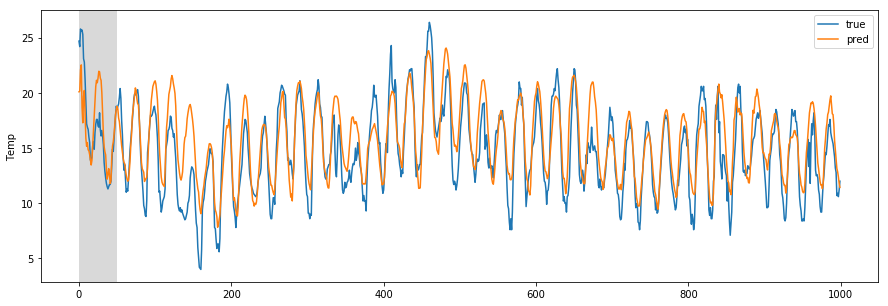

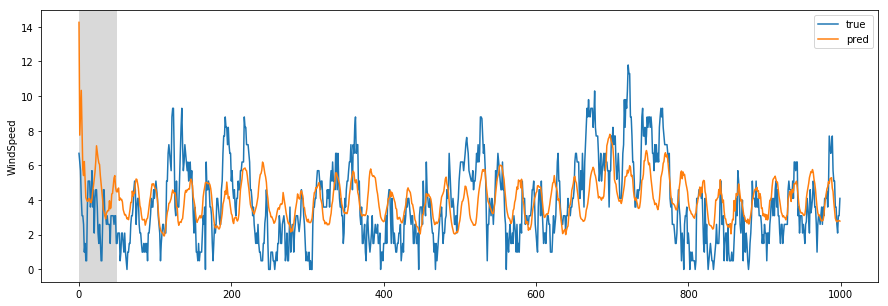

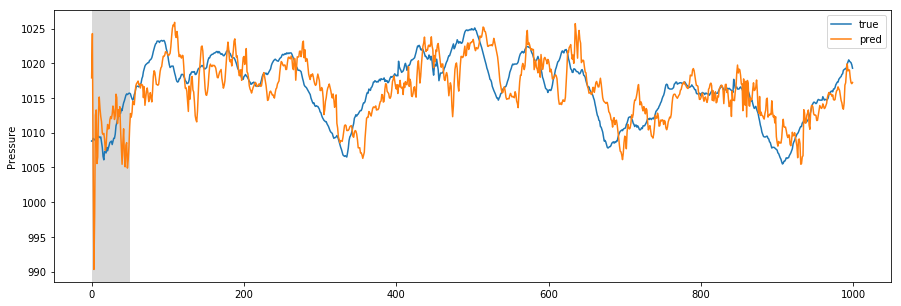

In [79]:
plot_comparison(start_idx=200, length=1000, train=False)

## 总结

这份教程展示如何用循环神经网络从大量的输入信号中预测几个时间序列。我们用了5个城市的天气数据去预测其中一个城市未来的天气。


它对于预测每日气温的振荡预测的相当好，但是有时候峰值预测的不准确。对于气压的预测也非常好，尽管预测的信号有更多的噪声和一个小的滞后。对于风速的预测不是很好。

您可以在不同的时间序列中使用这个方法，但是您应该小心地区分数据中的*因果关系和相关性*。

神经网络可以很容易地发现数据中的模式，这些模式只是暂时的相关，不能很好地推广到没有见过的数据。

你应该选择可能存在*因果关系和相关性*的输入和输出数据。你应该有大量的数据用于训练，你应该尝试减少模型对训练数据过拟合的风险，例如我们在这个教程中用到了early-stopping。


## 练习

下面使一些可能会让你提升TensorFlow技能的一些建议练习。为了学习如何更合适地使用TensorFlow，实践经验是很重要的。

在你对这个Notebook进行修改之前，可能需要先备份一下。

* 从数据集中移除风速。对于温度和压力的预测有提高吗？
* 训练更多epoch，用更小的学习率。在测试集上的性能有提高吗？
* 尝试不同结构的神经网络，例如改变GRU层的状态大小，更多的GRU层，在GRU之前或之后的全连接层，等等。
* 使用教程 #19中的超参数优化。
* 改变批生成器产生序列的长度。
* 尝试在输入信号中移除 "Odense"。
* 尝试在输入信号中加入去年的天气数据。
* 模型对未来3天或7天的预测表现的怎么样？
* 你能不能训练带有输出信号的单独模型，可以进行多次的时间转换，这样一个模型就可以预测1、3和7天的天气。.
* 向朋友解释程序是如何工作的

## License (MIT)

Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.